In [1]:
using Statistics
using StatsBase
using Distributions
using Plots
using FFTW


(process:5712): GLib-GIO-WARNING **: 08:18:40.380: Unexpectedly, UWP app `D5BE6627.UltraZipOpener_2.0.6.0_neutral__9pm2v9747qaaa' (AUMId `D5BE6627.UltraZipOpener_9pm2v9747qaaa!App') supports 127 extensions but has no verbs

(process:5712): GLib-GIO-WARNING **: 08:18:41.463: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs

(process:5712): GLib-GIO-WARNING **: 08:18:43.074: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.1.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


# How to determine the domain for a plot?

### Defining some constants

In [45]:
max_plot_width = 4096

magic_number_for_quantiles = 2000

plot_buffer = 0.15
q_for_plot = 1/2000

fft_q_limit = 1e-18
fft_buffer = 0.15

0.15

In [46]:
function quantile_ecdf(empirical_cdf, q)
    if (q < 0.0001) | (q > 0.9999)
        throw(DomainError(q, "The quantile is too extreme!"))
    end
    mmin, mmax = extrema(empirical_cdf)
    wdth = (mmax - mmin)
    stp = wdth / magic_number_for_quantiles
    rng = mmin:stp:mmax
    return rng[findfirst(x -> empirical_cdf(x) >= q, rng)]
end

function grid_for_plot(e_cdf)
    mmin, mmax = quantile_ecdf(e_cdf, q_for_plot), quantile_ecdf(e_cdf, 1 - q_for_plot)
    wdth = (mmax - mmin)
    stp = wdth * plot_buffer / max_plot_width
    return (mmin - wdth*plot_buffer):stp:(mmax + wdth*plot_buffer)
end

grid_for_plot (generic function with 1 method)

### Example: empirical distribution

We define here an empirical distribution, providing some weights to the observations that underly the cdf

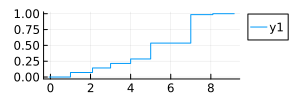

In [47]:
observations = [1, 2.1, 3, 4, 5, 7, 8.1]
weights = Weights([1, 1, 1, 1, 3.5, 6.3, 0.2])
empirical_distribution = ecdf(observations; weights)
    
#plotting
gfp = grid_for_plot(empirical_distribution)
plot(gfp, [empirical_distribution(x) for x in gfp], size = (300, 100), legend=:outertopright)

# Convolution of two distributions, FFT

In [48]:
#defining plane convolution
function slow_convolution(v_1, v_2)
    for x in base_points_1
        l = div(x, step)
        tot = 0
        for i in 0:(l-1)
            tot += v_1[i + 1] * v_2[l-i]
        end
        push!(convolution, tot)
    end
    return convolution
end

slow_convolution (generic function with 1 method)

In [49]:
#defining convolution with fft
function fft_conv(d_1, d_2)
    q = max(quantile(d_1, 1-1e-18), quantile(d_2, 1-fft_q_limit))
    println(q)
    grid = 0:1:round(q * (1 + fft_buffer))
    vector_values_1 = [pdf(d_1, x) for x in grid]
    vector_values_2 = [pdf(d_2, x) for x in grid]
    vector_conv = real(ifft(fft(vector_values_1).*fft(vector_values_2)))
    weights = Weights(vector_conv)
    return ecdf(grid; weights)
end

fft_conv (generic function with 1 method)

### Example: convolution with binomial distributions

2000


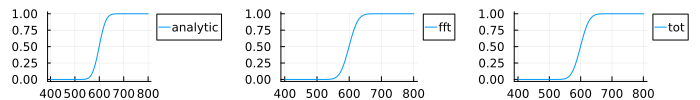

In [50]:
b_1, b_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
cv_analytic = convolve(b_1, b_2)
cv_fft = fft_conv(b_1, b_2)
xs_test = 400:800
p_analytic = plot(xs_test, [cdf(cv_analytic, x) for x in xs_test])
p_fft = plot(xs_test, [cv_fft(x) for x in xs_test])
p_tot = plot(xs_test, [cdf(Binomial(3000, 0.2), x) for x in xs_test])
plot(p_analytic, p_fft, p_tot, layout = (1, 3), size = (700, 100), label=["analytic" "fft" "tot"], legend=:outertopright)

### Example: FFT and histogram

In [57]:
quantile(Poisson(400), 1-fft_q_limit)

LoadError: InexactError: Int64(Inf)

In [59]:
1.0-fft_q_limit

1.0

In [55]:
distribution_1, distribution_2 = Poisson(400), NegativeBinomial(500, 0.2)
nr_draws = 1000
draws = [rand(distribution_1) + rand(distribution_2) for x in 1:nr_draws]
distribution_fft = fft_conv(distribution_1, distribution_2)

rangg = grid_for_plot(distribution_fft)
histo_cdf = [count(draws .< x) for x in rangg] ./ nr_draws

plot(rangg, histo_cdf)
plot!(rangg, [distribution_fft(x) for x in rangg])

LoadError: InexactError: Int64(Inf)

# Frequency-severity model

In [9]:
struct FrequencySeverity{F <: DiscreteUnivariateDistribution, S <: ContinuousUnivariateDistribution} 
    frequency::F
    severity::S
end

In [10]:
function StatsBase.rand(fs::FrequencySeverity)::Real
    tot = 0
    f = rand(fs.frequency)
    if f == 0 return 0 end
    for i in 1:f
        tot += rand(fs.severity)
    end
    return tot
end

function StatsBase.rand(fs::FrequencySeverity, n::Int)
    return [StatsBase.rand(fs) for x in 1:n]
end

### Example: frequency-severity model with Poisson and Gamma distributions

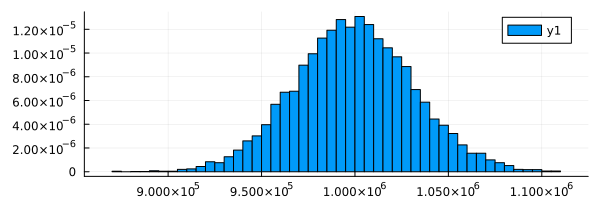

In [11]:
example_frequency = Poisson(1000)
example_severity = Gamma(100, 10)
ex_d = FrequencySeverity(example_frequency, example_severity)
draws = rand(ex_d, 10_000)
histogram(draws, norm = true, size = (600, 200))

### The quantile-estimation of a frequency-severity model

In [12]:
function top_quantile_approximation(fs::FrequencySeverity)
    q = quantile(fs.severity, 1 - (1 - fft_q_limit)/mean(fs.frequency))
    #correction for better convergence
    q += (mean(fs.frequency) - 1)*mean(fs.severity)
    return q
end

top_quantile_approximation (generic function with 1 method)

### Example: Approximation of top quantile

In [13]:
fs_pareto = Pareto(3, 100000)
fs_poisson = Poisson(400)
ex_fs = FrequencySeverity(fs_poisson, fs_pareto)
fs_draws = rand(ex_fs, 200_000)
ccdf = ecdf(fs_draws)

#emprical quantile
findfirst(x -> x >= 0.999, [ccdf(x) for x in 1:2000])

In [14]:
top_quantile_approximation(ex_fs)

6.058680629972808e7

# FFT for the frequency-severity model

### Define moment-generating function for complex values

In [15]:
function Distributions.mgf(d::Poisson, t::Complex)
    λ = rate(d)
    return exp(λ * (exp(t) - 1))
end

### FFT algorithms

In [16]:
function FFTW.fft(freq_sev::FrequencySeverity)
    e_end = round(Int, top_quantile_approximation(freq_sev) * fft_buffer)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    println(e_end)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[2:end]; weights = real(ifft(total_claim_amount_ft)))
end

function fft_bot(freq_sev::FrequencySeverity)
    e_end = round(Int, top_quantile_approximation(freq_sev) * fft_buffer)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[1:(end - 1)]; weights = real(ifft(total_claim_amount_ft)))
end

function fft_top(freq_sev::FrequencySeverity)
    e_end = round(Int, top_quantile_approximation(freq_sev) * fft_buffer)
    stp = 1000
    rng = 0:stp:(e_end-1)
    stps = length(rng)
    step_pdf = cdf.(freq_sev.severity, rng[2:end]) .- cdf.(freq_sev.severity, rng[1:(end - 1)])
    severity_ft = fft(step_pdf)
    total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
    return ecdf(rng[2:end]; weights = real(ifft(total_claim_amount_ft)))
end

fft_top (generic function with 1 method)

### Example: frequency-severity model with Poisson and Gamma

In [17]:
fs = FrequencySeverity(Poisson(1000), Gamma(100, 10))

convolution_fs_bot = fft_bot(fs)
convolution_fs_top = fft_top(fs)

ECDF{StepRange{Int64, Int64}, Weights{Float64, Float64, Vector{Float64}}}(1000:1000:50000, [0.01977746863590019, 0.019674895784835843, 0.019577449950728843, 0.01948666780917535, 0.019403980956301276, 0.019330693337446858, 0.019267960687927754, 0.019216772309805136, 0.019177935471842007, 0.019152062678552087  …  0.02072290780888169, 0.020658440506359354, 0.020583589510620275, 0.020499535332066398, 0.020407603597391903, 0.020309244141013916, 0.020206008139309506, 0.020099523648329256, 0.019991469930728638, 0.019883550976649417])

0
49284


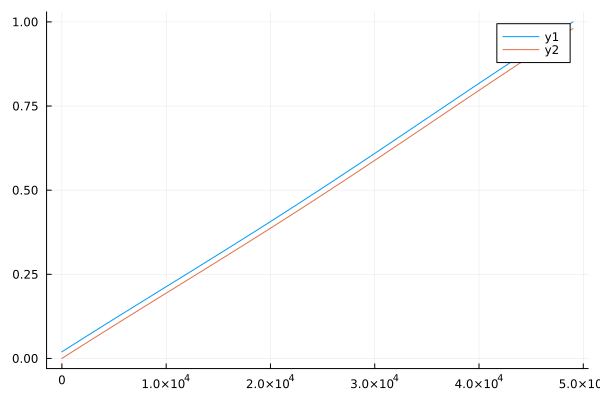

In [18]:
observation_plot = plot()

bot = first(Iterators.filter(x -> convolution_fs_bot(x) > 0.00001, [t^2 for t in 0:100000]))

top = first(Iterators.filter(x -> convolution_fs_bot(x) > 0.99999, [t^2 for t in 0:100000]))
println(bot)
println(top)

plot!(bot:1000:top, [convolution_fs_bot(x) for x in bot:1000:top])
plot!(bot:1000:top, [convolution_fs_top(x) for x in bot:1000:top])

display(observation_plot)

# FFT for $F(x^2)$

### Panjer Algorithm